In [6]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from rasterio.errors import RasterioIOError
import csv
from skimage import io
import requests
from PIL import Image
from io import BytesIO

In [7]:
tile = '11SKU'
location = 'Isla_Vista_Kelp'
cloud_cover_threshold = .05
save_mask = True
save_classification = True
path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery',location,tile)
num_iterations = 30

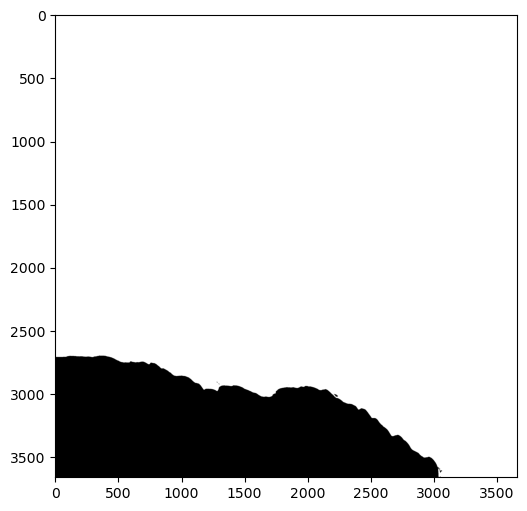

In [8]:
granules = os.listdir(path)

for item in granules:
    
    if os.path.isdir(os.path.join(path,item)):
        img_path = os.path.join(path,item)
        granule = item
        break
    else:
        continue
files = os.listdir(img_path)
file_data = granule.split('.')
sensor = file_data[1]
if(sensor == 'L30'):
    sensor_bands = ['B02','B03','B04','B05','B06','B07'] #2,3,4,5,6,7]
else:
    sensor_bands = ['B02','B03','B04','B08A','B11','B12']
    
pattern = re.compile(r'\.(' + '|'.join(sensor_bands) + r')\.tif$')
img_files = [f for f in files if re.search(pattern, f)]

geotiff_path = os.path.join(img_path, img_files[0])

geotiff_path = os.path.join(img_path, img_files[0])

with rasterio.open(geotiff_path) as dst:   
    hls = dst.read()
    dem_path = r'C:\Users\attic\HLS_Kelp\imagery\Socal_DEM.tiff'
    dem = rasterio.open(dem_path)
    if (dem.crs != dst.crs):
        reprojected_dem = np.zeros((hls.shape[1], hls.shape[2]), dtype=hls.dtype)
        reproject(
            source=dem.read(),
            destination=reprojected_dem,
            src_transform=dem.transform,
            src_crs=dem.crs,
            dst_transform=dst.transform,
            dst_crs=dst.crs,
            resampling=Resampling.bilinear)
    hls_flat = np.squeeze(hls, axis=0)   

if reprojected_dem.any():
    struct = np.ones((5,5))
    land_mask = binary_dilation(reprojected_dem > 0, structure = struct)
    ocean_mask = binary_dilation(reprojected_dem < -60 , structure = struct)
    full_mask = land_mask + ocean_mask
    plt.figure(figsize=(6, 6))
    plt.imshow(land_mask, cmap='gray')
    plt.show()    
    # plt.figure(figsize=(6, 6))
    # plt.imshow(full_mask, cmap='gray')
    # plt.show()
    if save_mask:
        mask_path = os.path.join(path,f'{tile}_fullmask.tif')
        transform = dst.transform  
        height, width = full_mask.shape
        profile = {
            'driver': 'GTiff',
            'width': width,
            'height': height,
            'count': 1,  # one band
            'dtype': rasterio.uint8,  # assuming binary mask, adjust dtype if needed
            'crs': dst.crs,
            'transform': transform,
            'nodata': 0  # assuming no data is 0
        }

        # Write the land mask array to GeoTIFF
        with rasterio.open(mask_path, 'w', **profile) as dst:
            dst.write(full_mask.astype(rasterio.uint8), 1)
else:
    print("Something failed, you better go check...")


In [9]:
iterations = 0
for item in granules:
    if iterations > num_iterations:
        break
 ##==========Select Granule and Get File Names==========##
    if os.path.isdir(os.path.join(path,item)):
        img_path = os.path.join(path,item)
    else:
        continue

    img_path = os.path.join(path,item)
    files = os.listdir(img_path)
    file_data = item.split('.')
    sensor = file_data[1]
    if(sensor == 'L30'):
        sensor_bands = ['B02','B03','B04','B05','B06','B07'] #2,3,4,5,6,7]
    else:
        sensor_bands = ['B02','B03','B04','B08A','B11','B12']
    pattern = re.compile(r'\.(' + '|'.join(sensor_bands) + r')\.tif$')
    img_files = [f for f in files if re.search(pattern, f)]

    f_mask = [f for f in files if re.search(r'Fmask\.tif$', f)]
    if not f_mask:
        print(f"Invalid granule: {item}")
        continue
    if not len(img_files)  == 6:
        print(f"incomplete file download: {item}")
        continue
    img_bands = []
    metadata_file = [f for f in files if re.search(r'metadata\.csv$', f)]
    if metadata_file :
        with open(os.path.join(path,item, metadata_file[0]), mode='r') as file:
            csv_reader = csv.reader(file)
            keys = next(csv_reader)  
            values = next(csv_reader) 
        metadata = dict(zip(keys, values))

    ##==========Fmask Cloud mask==========##
    #bitwise operations are weird. Far outside my comfort zone. Need to take CS33 first.........
    with rasterio.open(os.path.join(img_path,f_mask[0])) as fmask:
        qa_band = fmask.read(1)
    qa_bit = (1 << 1) - 1
    qa_cloud_mask = ((qa_band >> 1) & qa_bit) == 1  # Bit 1 for cloud
    qa_adjacent_to_cloud_mask = ((qa_band >> 2) & qa_bit) == 1  # Bit 2 for cloud adjacent
    qa_cloud_shadow = ((qa_band >> 3) & qa_bit) == 1 
    qa_ice = ((qa_band >> 4) & qa_bit) == 1 
    #qa_water = ((qa_band >> 5) & qa_bit) == 1
    qa_aerosol = (((qa_band >> 6) & 1) == 1) & (((qa_band >> 7) & 1) == 1)
    cloud_mask = qa_cloud_mask | qa_adjacent_to_cloud_mask | qa_cloud_shadow | qa_ice | qa_aerosol#Mask out Clouds and cloud-adjacent pixels 
    cloud_mask_2D = cloud_mask.reshape(-1).T
    #may not be necessary to mask out the cloud-adjacent pixels 
    #print(img_2D_normalized.shape)
    #print(cloud_mask_2D.shape)

    ##========== Determine percentage of ocean covered by clouds ==========##
    cloud_land_mask = cloud_mask | land_mask
    cloud_but_not_land_mask = cloud_mask & ~land_mask
    num_pixels_cloud_not_land = np.count_nonzero(cloud_but_not_land_mask)
    num_pixels_not_land = np.count_nonzero(land_mask)
    percent_cloud_covered = num_pixels_cloud_not_land/num_pixels_not_land
    if(percent_cloud_covered > cloud_cover_threshold):
        continue
    print(f'Percent cloud covered: {percent_cloud_covered}')
    
 ##==========Create stacked np array, Apply landmask==========##
    try:
        for file in img_files:
            with rasterio.open(os.path.join(img_path, file)) as src:
                img_bands.append(np.where(cloud_land_mask, 0, src.read(1)))  # Create image with the various bands
    except RasterioIOError as e:
        print(f"Error reading file {file} in granule {item}: {e}")
        continue  # Skip to the next granule if a file cannot be read

    img = np.stack(img_bands, axis=0)
    n_bands, height, width = img.shape
    img_2D = img.reshape(img.shape[0], -1).T #classifier takes 2D array of band values for each pixel 

 ##========== Normalize multi-spectral data ==========##

    img_sum = img_2D.sum(axis=1)
    img_2D_normalized  = img_2D / img_sum[:,None] #divide value by sum of pixel band values
    img_2D_normalized = (img_2D_normalized * 255)
    img_2D_normalized = img_2D_normalized.astype(np.uint8)

    normalized_img_bands = np.column_stack((img_2D_normalized, cloud_mask_2D))
    #print(normalized_img_bands.shape)
 ##========== Add masked file-folder to directory, if needed ==========##
    if not os.path.isdir (r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped'):
        os.mkdir(r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped')
    classification_path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery\rf_prepped',f'{item}_rf_ready.tif')
    transform = dst.transform  
    normalized_img_bands = normalized_img_bands.reshape(height, width, 7)

    # plt.figure(figsize=(10, 10))
    # plt.imshow(normalized_img_bands[:,:,4], cmap='gray')
    # plt.show()

    # urls = metadata['data_vis_url']
    # img_urls = urls.strip("[]").replace("'", "").split(", ")
    # print(img_urls)
    # response = requests.get(img_urls[0])
    # img = Image.open(BytesIO(response.content))
    # img.show()


 ##========== Save masked file ==========##

    num_bands = 6
    data_type = rasterio.uint8
    profile = {
        'driver': 'GTiff',
        'width': width,
        'height': height,
        'count': 6,  # one band
        'dtype': data_type,  # assuming binary mask, adjust dtype if needed
        'crs': dst.crs,
        'transform': transform,
        'nodata': 0,  # assuming no data is 0
        'cloud_cover': percent_cloud_covered
    }
    # Write the land mask array to GeoTIFF
    with rasterio.open(classification_path, 'w', **profile) as dst:
        for i in range(num_bands):
            dst.write(normalized_img_bands[:,:,i].astype(data_type), i + 1)
    iterations = iterations + 1


Percent cloud covered: 0.0464060120461955


C:\Users\attic\AppData\Local\Temp\ipykernel_1656\4062449717.py:81: RuntimeWarning: divide by zero encountered in divide
  img_2D_normalized  = img_2D / img_sum[:,None] #divide value by sum of pixel band values
C:\Users\attic\AppData\Local\Temp\ipykernel_1656\4062449717.py:81: RuntimeWarning: invalid value encountered in divide
  img_2D_normalized  = img_2D / img_sum[:,None] #divide value by sum of pixel band values
C:\Users\attic\AppData\Local\Temp\ipykernel_1656\4062449717.py:83: RuntimeWarning: invalid value encountered in cast
  img_2D_normalized = img_2D_normalized.astype(np.uint8)


Percent cloud covered: 9.522020224346576e-05
Percent cloud covered: 0.015675437917886944
Percent cloud covered: 0.047818047190142016
Percent cloud covered: 0.0023010222688843456
Percent cloud covered: 0.001430159694977068
Percent cloud covered: 0.021099895010222688
Percent cloud covered: 0.03590933303862519
Percent cloud covered: 0.00034330552025197547
Percent cloud covered: 0.017220622202575014
Percent cloud covered: 0.0001060065204177488
Percent cloud covered: 0.00033216555230148643
Percent cloud covered: 2.431342211416257e-05
Percent cloud covered: 0.0030208763883516603
Percent cloud covered: 7.09951925733547e-05
Percent cloud covered: 0.04230783002707631
Percent cloud covered: 0.0010979941426755816
Percent cloud covered: 0.00015498701442227992
Percent cloud covered: 2.6258495883295575e-05
Percent cloud covered: 1.8566613250815053e-05
Percent cloud covered: 8.301928496435874e-05
Percent cloud covered: 0.0006742332983367409
Percent cloud covered: 0.0039821848925236224
Percent cloud c